In [36]:
import sys
sys.path.append('../scripts/')

from time import time
import glob
import warnings
import param

import numpy as np
import pandas as pd
import xarray as xr
from scipy.special import gammaln
from scipy.optimize import curve_fit, minimize
from scipy.stats import pearsonr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from epsilon_tools import *
from tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind',font_scale=1.5)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

%matplotlib inline

In [2]:
ds = xr.open_dataset('../data/chi/variable_dof.nc')

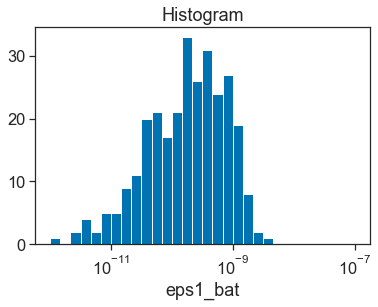

In [3]:
ind, bins = np.histogram(ds.eps1_bat, bins=30, range=(1e-12,1e-7));

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

ds.eps1_bat.plot.hist(xscale='log', bins=logbins);

In [284]:
ds['itime'] = ('time',np.arange(0,len(ds.time)))

hover_cols = ['eps_rc','chi1','lhr1_bat','kb1_bat']
arguments = {'hover_cols':hover_cols,'legend':'left','groupby':'itime','loglog':True}

obs = ds.hvplot(x='k_rpm',y='corrdTdzsp1_rpm',label='Observed',**arguments)
noi = ds.hvplot(x='k_rpm',y='noise_rpm',label='Noise',line_dash='dotted',**arguments)
bat = ds.hvplot(x='k_rpm',y='bat1',label='Batchelor',**arguments)
krai = ds.hvplot(x='k_rpm',y='kra1',label='Kraichnan',**arguments)
power = ds.hvplot(x='k_rpm',y='power1',label='Power law',line_dash='dashed',**arguments)
rc = ds.hvplot(x='k_rpm',y='bat1_rc',label='Ren-Chieh',**arguments)

In [285]:
(obs*bat*krai*rc*power*noi).options(height=600,ylim=(1e-9, 1e-2),xlim=(1e1,2e3),
                      title=f'Temperature Gradient Spectra',
                      xlabel=r'k_z',ylabel='dPhidz',
                      fontsize={'title': 16, 'labels': 14, 'xticks': 12, 'yticks': 12, 'legend':12})

:DynamicMap   [itime]
   :Overlay
      .Curve.Observed               :Curve   [k_rpm]   (corrdTdzsp1_rpm,eps_rc,chi1,lhr1_bat,kb1_bat)
      .Curve.Batchelor              :Curve   [k_rpm]   (bat1,eps_rc,chi1,lhr1_bat,kb1_bat)
      .Curve.Kraichnan              :Curve   [k_rpm]   (kra1,eps_rc,chi1,lhr1_bat,kb1_bat)
      .Curve.Ren_hyphen_minus_Chieh :Curve   [k_rpm]   (bat1_rc,eps_rc,chi1,lhr1_bat,kb1_bat)
      .Curve.Power_law              :Curve   [k_rpm]   (power1,eps_rc,chi1,lhr1_bat,kb1_bat)
      .Curve.Noise                  :Curve   [k_rpm]   (noise_rpm,eps_rc,chi1,lhr1_bat,kb1_bat)

(1e-12, 0.001)

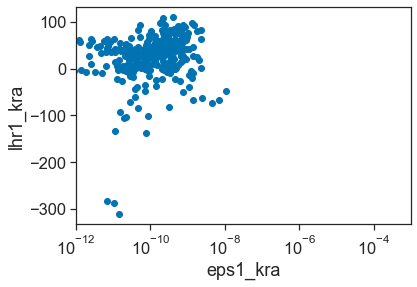

In [6]:
ds.plot.scatter(x='eps1_kra',y='lhr1_kra')
# plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-12,1e-3)
# plt.ylim(1e-12,1e-3)

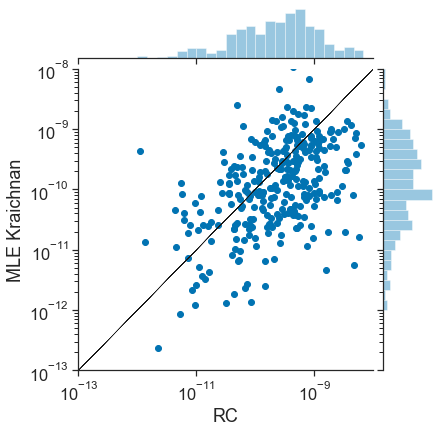

In [11]:
ind, bins = np.histogram(ds.eps_rc, bins=30, range=(1e-12,1e-7));
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

g = sns.jointplot(x='eps_rc',y='eps1_kra',data=ds, kind='scatter',dropna=True,
             xlim=(1e-13,1e-8),ylim=(1e-13,1e-8), marginal_kws={'bins':logbins} )
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')
g.ax_joint.set_xlabel('RC')
g.ax_joint.set_ylabel('MLE Kraichnan')

g.ax_joint.plot(ds.eps_rc, ds.eps_rc, color='k', lw=0.2)

plt.savefig('../figures/rc_vs_mle_kraich.pdf')

In [90]:
from scipy.stats import pearsonr

In [151]:
ds['ratio_bat'] = ds.eps_rc/ds.eps1_bat
ds['ratio_kra'] = ds.eps_rc/ds.eps1_kra

ds['var_y_bat1'] = ds.y_bat1.var(dim='f_cps')
ds['var_y_kra1'] = ds.y_kra1.var(dim='f_cps')

In [119]:
pdf = xr.Dataset()
pdf['rc'] = np.log10(ds.eps_rc)
pdf['mle'] = np.log10(ds.eps1_bat)

In [120]:
pdf = pdf.dropna(dim='time',how='any')

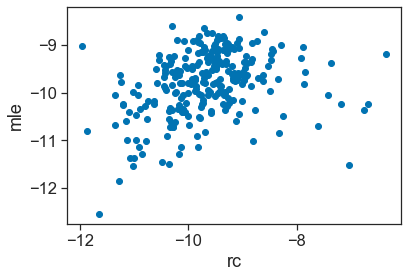

In [121]:
pdf.plot.scatter(x='rc',y='mle')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1e-12,1e-8)
# plt.ylim(1e-12,1e-8)

In [123]:
r,p = pearsonr(pdf.rc,pdf.mle)
print(r,p)

0.30696402542819007 3.2787905092410854e-07


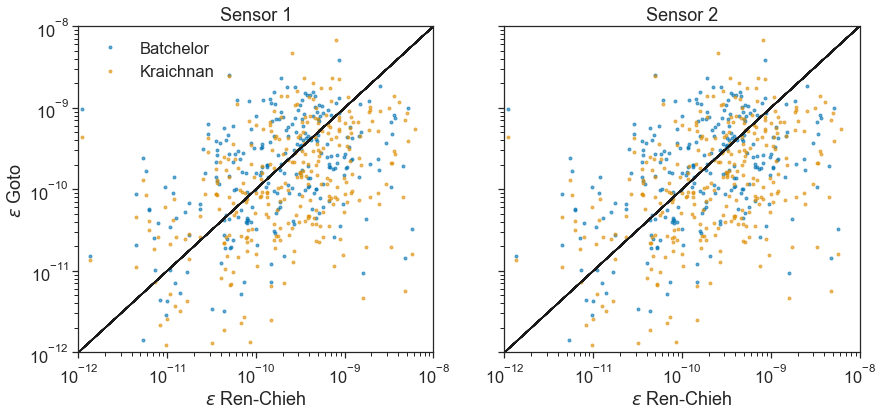

In [124]:
f,ax = plt.subplots(1,2,figsize=(14,6), sharey =True)
ax[0].plot( ds.eps_rc, ds.eps1_bat,'.',label='Batchelor', alpha=0.6)
ax[0].plot( ds.eps_rc, ds.eps1_kra,'.',label='Kraichnan', alpha=0.6)

ax[0].plot( ds.eps_rc, ds.eps_rc, color='k')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlim(1e-12,1e-8)
ax[0].set_ylim(1e-12,1e-8)
ax[0].set_xlabel(r'$\epsilon$ Ren-Chieh')
ax[0].set_ylabel(r'$\epsilon$ Goto')
ax[0].set_title(r'Sensor 1')
ax[0].legend()

ax[1].plot( ds.eps_rc, ds.eps2_bat,'.',label='Batchelor', alpha=0.6)
ax[1].plot( ds.eps_rc, ds.eps2_kra,'.',label='Kraichnan', alpha=0.6)
ax[1].plot( ds.eps_rc, ds.eps_rc, color='k')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlim(1e-12,1e-8)
ax[1].set_ylim(1e-12,1e-8)
ax[1].set_xlabel(r'$\epsilon$ Ren-Chieh')
ax[1].set_title(r'Sensor 2')
plt.savefig('../figures/scatter_goto_vs_rc_2sensors.pdf')
plt.show()

In [138]:
def plot_mad(ax,ds,sensor,mad_max,title,ylabel,xlabel):
    
    
    ax.plot( ds.mad1_bat, ds.ratio_bat,'.',label='MLE Batchelor', alpha=0.4)
    ax.plot( ds.mad1_kra, ds.ratio_kra,'.',label='MLE Kraichnan', alpha=0.4)
#         ax.plot( ds.mad1_rc, ds.eps_rc,'.',label='Ren-Chieh', alpha=0.4)
    ax.annotate(f'{mad_max:1.2f}',(mad_max+0.1,2e-12))
    leg = ax.legend(handletextpad=0.05, markerscale=1.5)
    ax.set_ylabel(ylabel)
    for lh in leg.legendHandles: 
        lh._legmarker.set_alpha(1)
        ax.set_yscale('log')
        
    ax.set_xscale('log')
    ax.set_xlim(1e-1,1e2)
#     ax.set_ylim(1e-12,1e-7)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.axvline(mad_max, color='k', ls='dashed')

(0.01, 1000.0)

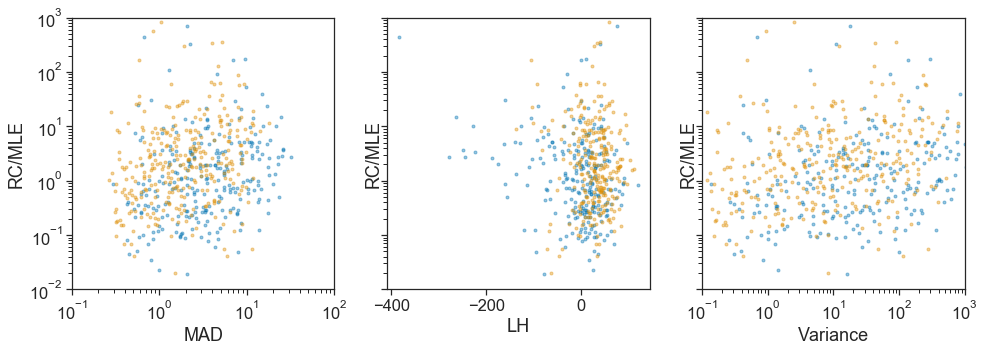

In [154]:
f,ax = plt.subplots(1,3,figsize=(16,5),sharey =True)

ax[0].plot( ds.mad1_bat, ds.ratio_bat,'.',label='MLE Batchelor', alpha=0.4)
ax[0].plot( ds.mad1_kra, ds.ratio_kra,'.',label='MLE Kraichnan', alpha=0.4)
ax[0].set_ylabel('RC/MLE')
ax[0].set_xlabel('MAD')
ax[0].set_xscale('log')
ax[0].set_xlim(1e-1,1e2)
ax[0].set_yscale('log')
ax[0].set_ylim(1e-2,1e3)

ax[1].plot( ds.lhr1_bat, ds.ratio_bat,'.',label='MLE Batchelor', alpha=0.4)
ax[1].plot( ds.lhr1_kra, ds.ratio_kra,'.',label='MLE Kraichnan', alpha=0.4)
ax[1].set_ylabel('RC/MLE')
ax[1].set_xlabel('LH')
# ax[1].set_xscale('log')
# ax[1].set_xlim(1e-1,1e2)
ax[1].set_yscale('log')
ax[1].set_ylim(1e-2,1e3)

ax[2].plot( ds.var_y_bat1, ds.ratio_bat,'.',label='MLE Batchelor', alpha=0.4)
ax[2].plot( ds.var_y_kra1, ds.ratio_kra,'.',label='MLE Kraichnan', alpha=0.4)
ax[2].set_ylabel('RC/MLE')
ax[2].set_xlabel('Variance')
ax[2].set_xscale('log')
ax[2].set_xlim(1e-1,1e3)
ax[2].set_yscale('log')
ax[2].set_ylim(1e-2,1e3)

In [163]:
from matplotlib.colors import LogNorm

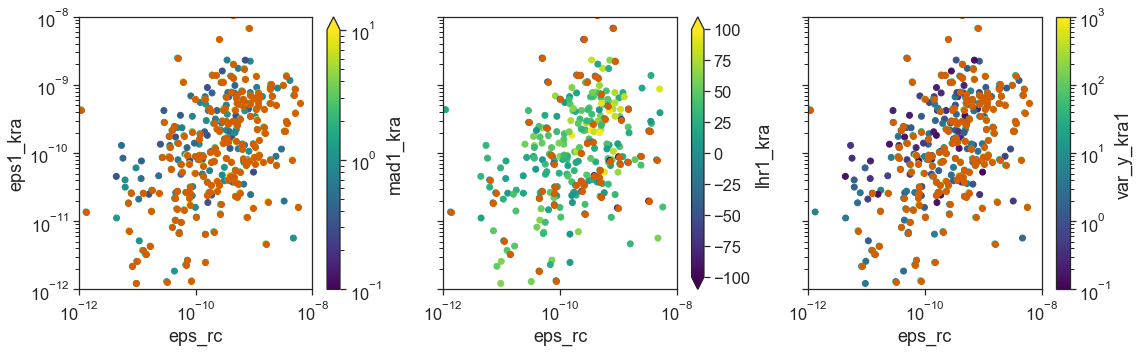

In [281]:
f,ax = plt.subplots(1,3,figsize=(16,5),sharey =True)

ds.plot.scatter(x='eps_rc',y='eps1_kra', hue='mad1_kra', ax=ax[0],norm=LogNorm(vmin=1e-1,vmax=1e1))
ds.where(ds.mad1_kra>1.2).plot.scatter(x='eps_rc',y='eps1_kra', ax=ax[0], color='r')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlim(1e-12,1e-8)
ax[0].set_ylim(1e-12,1e-8)

ds.plot.scatter(x='eps_rc',y='eps1_kra', hue='lhr1_kra', ax=ax[1], cmap='viridis', vmin=-100,vmax=100)
ds.where(ds.lhr1_kra<2).plot.scatter(x='eps_rc',y='eps1_kra', ax=ax[1], color='r')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlim(1e-12,1e-8)
ax[1].set_ylim(1e-12,1e-8)
ax[1].set_ylabel(None)
ds.plot.scatter(x='eps_rc',y='eps1_kra', hue='var_y_kra1', ax=ax[2],norm=LogNorm(vmin=1e-1,vmax=1e3))
ds.where(ds.var_y_kra1>6).plot.scatter(x='eps_rc',y='eps1_kra', ax=ax[2], color='r')
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_xlim(1e-12,1e-8)
ax[2].set_ylim(1e-12,1e-8)
ax[2].set_ylabel(None)
plt.tight_layout()
plt.show()

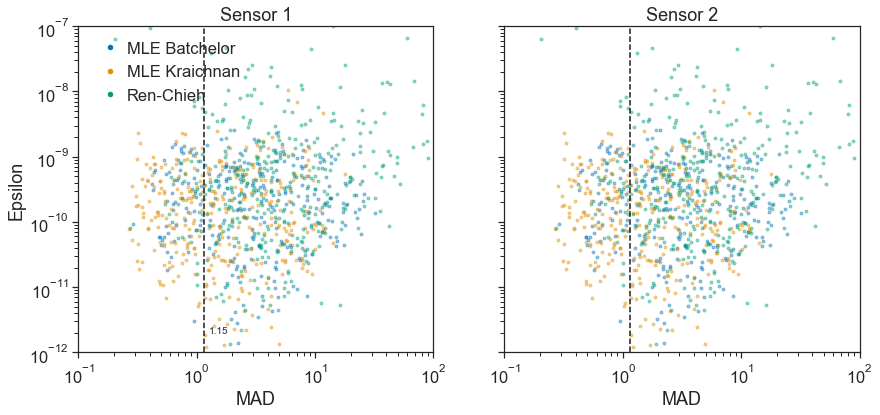

In [125]:
def plot_mad(ax,ds,sensor,mad_max,title,ylabel,xlabel):
    if sensor==1:
        ax.plot( ds.mad1_bat, ds.eps1_bat,'.',label='MLE Batchelor', alpha=0.4)
        ax.plot( ds.mad1_kra, ds.eps1_kra,'.',label='MLE Kraichnan', alpha=0.4)
#         ax.plot( ds.mad1_rc, ds.eps_rc,'.',label='Ren-Chieh', alpha=0.4)
        ax.annotate(f'{mad_max:1.2f}',(mad_max+0.1,2e-12))
        leg = ax.legend(handletextpad=0.05, markerscale=1.5)
        ax.set_ylabel(ylabel)
        for lh in leg.legendHandles: 
            lh._legmarker.set_alpha(1)
    elif sensor==2:
        ax.plot( ds.mad2_bat, ds.eps2_bat,'.',label='MLE Batchelor', alpha=0.4)
        ax.plot( ds.mad2_kra, ds.eps2_kra,'.',label='MLE Kraichnan', alpha=0.4)
        ax.plot( ds.mad2_rc, ds.eps_rc,'.',label='Ren-Chieh', alpha=0.4)
    else:
        raise ValueError('Only 2 sensors!')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1e-1,1e2)
    ax.set_ylim(1e-12,1e-7)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.axvline(mad_max, color='k', ls='dashed')
    
mad_max = 2*np.sqrt(2/6)
f,ax = plt.subplots(1,2,figsize=(14,6), sharey =True)
plot_mad(ax[0],ds,1,mad_max,'Sensor 1','Epsilon','MAD')
plot_mad(ax[1],ds,2,mad_max,'Sensor 2','Epsilon','MAD')

plt.savefig('../figures/scatter_mad_vs_eps_2sensors.pdf')
plt.show()

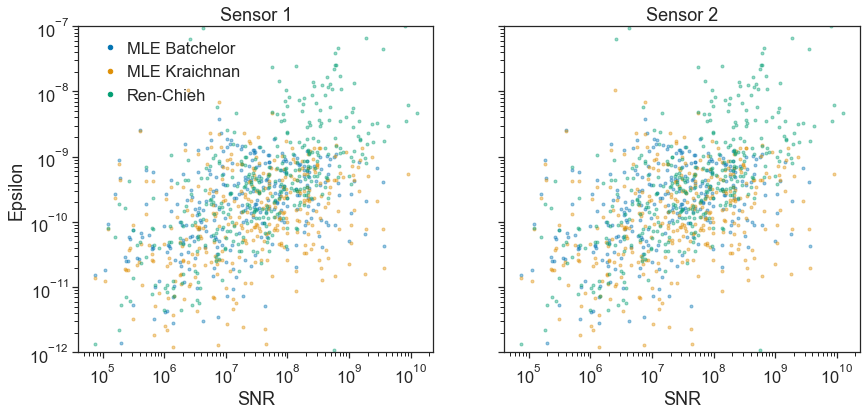

In [126]:
def plot_mad(ax,ds,sensor,mad_max,title,ylabel,xlabel):
    if sensor==1:
        ax.plot( ds.isnr1, ds.eps1_bat,'.',label='MLE Batchelor', alpha=0.4)
        ax.plot( ds.isnr1, ds.eps1_kra,'.',label='MLE Kraichnan', alpha=0.4)
        ax.plot( ds.isnr1, ds.eps_rc,'.',label='Ren-Chieh', alpha=0.4)
#         ax.annotate(f'{mad_max:1.2f}',(mad_max+0.1,2e-12))
        leg = ax.legend(handletextpad=0.05, markerscale=1.5)
        ax.set_ylabel(ylabel)
        for lh in leg.legendHandles: 
            lh._legmarker.set_alpha(1)
    elif sensor==2:
        ax.plot( ds.isnr2, ds.eps2_bat,'.',label='MLE Batchelor', alpha=0.4)
        ax.plot( ds.isnr2, ds.eps2_kra,'.',label='MLE Kraichnan', alpha=0.4)
        ax.plot( ds.isnr2, ds.eps_rc,'.',label='Ren-Chieh', alpha=0.4)
    else:
        raise ValueError('Only 2 sensors!')
    ax.set_yscale('log')
    ax.set_xscale('log')
#     ax.set_xlim(1e-1,1e1)
    ax.set_ylim(1e-12,1e-7)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
#     ax.axvline(mad_max, color='k', ls='dashed')
    
mad_max = 2*np.sqrt(2/6)
f,ax = plt.subplots(1,2,figsize=(14,6), sharey =True)
plot_mad(ax[0],ds,1,mad_max,'Sensor 1','Epsilon','SNR')
plot_mad(ax[1],ds,2,mad_max,'Sensor 2','Epsilon','SNR')

plt.savefig('../figures/scatter_mad_vs_eps_2sensors.pdf')
plt.show()

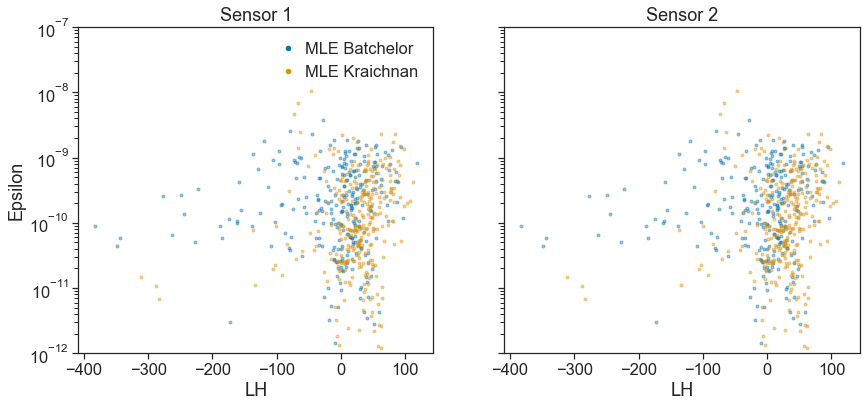

In [127]:
def plot_mad(ax,ds,sensor,mad_max,title,ylabel,xlabel):
    if sensor==1:
        ax.plot( ds.lhr1_bat, ds.eps1_bat,'.',label='MLE Batchelor', alpha=0.4)
        ax.plot( ds.lhr1_kra, ds.eps1_kra,'.',label='MLE Kraichnan', alpha=0.4)
#         ax.plot( ds.isnr1, ds.eps_rc,'.',label='Ren-Chieh', alpha=0.4)
#         ax.annotate(f'{mad_max:1.2f}',(mad_max+0.1,2e-12))
        leg = ax.legend(handletextpad=0.05, markerscale=1.5)
        ax.set_ylabel(ylabel)
        for lh in leg.legendHandles: 
            lh._legmarker.set_alpha(1)
    elif sensor==2:
        ax.plot( ds.lhr2_bat, ds.eps2_bat,'.',label='MLE Batchelor', alpha=0.4)
        ax.plot( ds.lhr2_kra, ds.eps2_kra,'.',label='MLE Kraichnan', alpha=0.4)
#         ax.plot( ds.isnr2, ds.eps_rc,'.',label='Ren-Chieh', alpha=0.4)
    else:
        raise ValueError('Only 2 sensors!')
    ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlim(-10,10)
    ax.set_ylim(1e-12,1e-7)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
#     ax.axvline(mad_max, color='k', ls='dashed')
    
mad_max = 2*np.sqrt(2/6)
f,ax = plt.subplots(1,2,figsize=(14,6), sharey =True)
plot_mad(ax[0],ds,1,mad_max,'Sensor 1','Epsilon','LH')
plot_mad(ax[1],ds,2,mad_max,'Sensor 2','Epsilon','LH')

plt.savefig('../figures/scatter_lhr_vs_eps_2sensors.pdf')
plt.show()

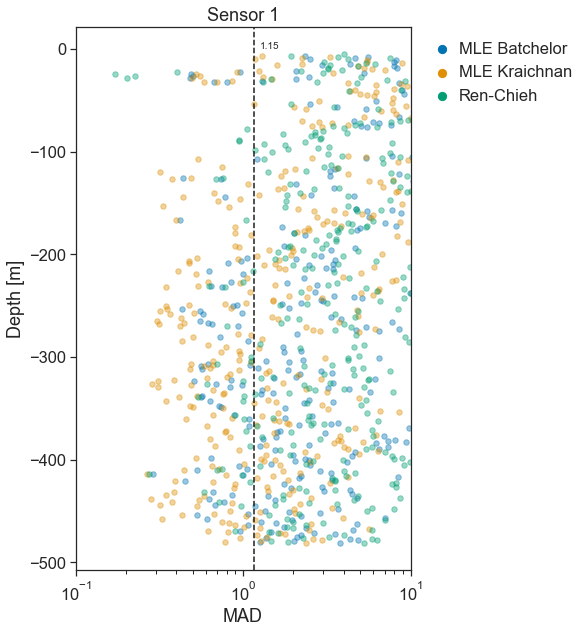

In [17]:
def scatter_mad_w_depth(ax,ds,sensor,mad_max,title,ylabel,xlabel):
    s=30
    if sensor==1:
        ax.scatter( ds.mad1_bat,ds.z,s,label='MLE Batchelor', alpha=0.4, color=None)
        ax.scatter( ds.mad1_kra,ds.z,s,label='MLE Kraichnan', alpha=0.4)
        ax.scatter( ds.mad1_rc,ds.z,s,label='Ren-Chieh', alpha=0.4)
        ax.annotate(f'{mad_max:1.2f}',(mad_max+0.1,2e-12))
        leg = ax.legend(handletextpad=0.05, markerscale=1.5, loc='upper left',
               bbox_to_anchor=(1, 1))
        ax.set_ylabel(ylabel)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    elif sensor==2:
        ax.scatter( ds.mad2_bat,ds.z,s,label='MLE Batchelor', alpha=0.4)
        ax.scatter( ds.mad2_kra,ds.z,s,label='MLE Kraichnan', alpha=0.4)
        ax.scatter( ds.mad2_rc,ds.z,s,label='Ren-Chieh', alpha=0.4)
    else:
        raise ValueError('Only 2 sensors!')
#     ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1e-1,1e1)
#     ax.set_ylim(1e-12,1e-7)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.axvline(mad_max, color='k', ls='dashed')
    
mad_max = 2*np.sqrt(2/6)
f,ax = plt.subplots(1,1,figsize=(6,10), sharey =True)
scatter_mad_w_depth(ax,ds,1,mad_max,'Sensor 1','Depth [m]','MAD')
plt.savefig('../figures/scatter_mad_vs_depth.pdf')
plt.show()

In [56]:
def alphabet(ax, **kwargs):
    for j, axx in enumerate(ax.flatten()):
        axx.annotate(chr(65+j), (0, 1.02),
                     xycoords='axes fraction',
                     weight='bold', **kwargs)

In [48]:
mad_max = np.sqrt( 2/ds.dof.mean(dim='time').mean() )
var_max = 2/ds.dof.mean(dim='time').mean()

In [67]:
def find_logbins(array,nbins,range):
    _, bins = np.histogram(array, bins=nbins, range=range)
    return np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

In [86]:
def ruddick_fig6_bat(ds):
    f,ax = plt.subplots(2,3,figsize=(20,12))

    logbins = find_logbins(ds.var_y_bat1, nbins=30, range=(1e-1,1e3))
    ds.var_y_bat1.plot.hist(density=True, range=(1e-1,1e3), xscale='log', ax=ax[0,0], bins=logbins)

    ax[0,0].set_xlabel('Variance')
    ax[0,0].set_ylabel('Frequency')
    ax[0,0].set_title(None)
    # ax[0,0].axvline(var_max, color='k')
    # ax[0,0].axvline(50*var_max, color='k')

    logbins = find_logbins(ds.mad1_bat, nbins=30, range=(1e-1,1e3))
    ds.mad1_bat.plot.hist(density=True, range=(1e-2,1e2), xscale='log', ax=ax[0,1], bins=logbins)
    ax[0,1].set_xlabel('MAD')
    ax[0,1].set_title(None)
    # ax[0,1].axvline(mad_max, color='k')

    ds.lhr1_bat.plot.hist(density=True, range=(-500,500), xscale='linear', ax=ax[0,2], bins=50)
    ax[0,2].set_xlabel('LH')
    ax[0,2].set_title(None)
    # ax[0,2].axvline(2, color='k')

    ds.plot.scatter(x='var_y_bat1', y='lhr1_bat', ax=ax[1,0])
    ax[1,0].set_xscale('log')
    ax[1,0].set_xlim(1e-1,1e4)
    ax[1,0].set_ylim(-500,500)
    ax[1,0].set_xlabel('Variance')
    ax[1,0].set_ylabel('LH')

    ds.plot.scatter(x='mad1_bat', y='lhr1_bat', ax=ax[1,1])
    ax[1,1].set_xscale('log')
    ax[1,1].set_xlim(1e-1,1e2)
    ax[1,1].set_ylim(-500,500)
    ax[1,1].set_xlabel('MAD')
    ax[1,1].set_ylabel('LH')

    ds.plot.scatter(x='mad1_bat', y='var_y_bat1', ax=ax[1,2])
    ax[1,2].set_xscale('log')
    ax[1,2].set_yscale('log')
    ax[1,2].set_xlim(1e-1,1e2)
    ax[1,2].set_ylim(1e-1,1e4)
    ax[1,2].set_xlabel('MAD')
    ax[1,2].set_ylabel('Variance')

    alphabet(ax,fontsize=22)

    plt.tight_layout()

    plt.savefig('../figures/ruddick_fig6_bat.pdf')
    plt.show()

In [276]:
def ruddick_fig6_kra(ds):
    f,ax = plt.subplots(2,3,figsize=(20,12))

    logbins = find_logbins(ds.var_y_kra1, nbins=30, range=(1e-1,1e3))
    ds.var_y_kra1.plot.hist(density=True, range=(1e-1,1e3), xscale='log', ax=ax[0,0], bins=logbins)
#     plt.hist(dataset, bins=bins, normed=True, cumulative=True, label='CDF DATA', 
#          histtype='step', alpha=0.55, color='purple')
    cdf = ax[0,0].twinx()
    ds.var_y_kra1.plot.hist(density=True, range=(1e-1,1e3), xscale='log', ax=cdf, bins=logbins, cumulative=True, histtype='step',color='k')
    cdf.set_title(None)
    
    ax[0,0].set_xlabel('Variance')
    ax[0,0].set_ylabel('Frequency')
    ax[0,0].set_title(None)
    ax[0,0].axvline(6, color='r')
    
    logbins = find_logbins(ds.mad1_kra, nbins=30, range=(1e-1,5e1))
    ds.mad1_kra.plot.hist(density=True, range=(1e-1,5e1), xscale='log', ax=ax[0,1], bins=logbins)
    
    cdf = ax[0,1].twinx()
    ds.mad1_kra.plot.hist(density=True, range=(1e-1,5e1), xscale='log', ax=cdf, bins=logbins, cumulative=True, histtype='step',color='k')
    cdf.set_title(None)
    ax[0,1].set_xlabel('MAD')
    ax[0,1].set_title(None)
    ax[0,1].axvline(3, color='r')

    ds.lhr1_bat.plot.hist(density=True, range=(-400,400), xscale='linear', ax=ax[0,2], bins=30)
    
    cdf = ax[0,2].twinx()
    ds.lhr1_bat.plot.hist(density=True, range=(-400,400), xscale='linear', ax=cdf, bins=30, cumulative=True, histtype='step',color='k')
    cdf.set_title(None)
    cdf.set_ylabel('CDF')
    ax[0,2].set_xlabel('LH')
    ax[0,2].set_title(None)
    ax[0,2].axvline(2, color='r')

    ds.plot.scatter(x='var_y_kra1', y='lhr1_kra', ax=ax[1,0])
    ax[1,0].set_xscale('log')
    ax[1,0].set_xlim(1e-1,1e3)
    ax[1,0].set_ylim(-400,400)
    ax[1,0].set_xlabel('Variance')
    ax[1,0].set_ylabel('LH')
#     ax[1,0].axvline(10, color='r')
#     ax[1,0].axhline(2, color='r')
    ax[1,0].fill_between(x=[1e-1,10],y1=2,y2=1e3, alpha=0.2)
    
    ds.plot.scatter(x='mad1_kra', y='lhr1_kra', ax=ax[1,1])
    ax[1,1].set_xscale('log')
    ax[1,1].set_xlim(1e-1,1e2)
    ax[1,1].set_ylim(-400,400)
    ax[1,1].set_xlabel('MAD')
    ax[1,1].set_ylabel('LH')
#     ax[1,1].axvline(3, color='r')
#     ax[1,1].axhline(2, color='r')
    ax[1,1].fill_between(x=[1e-2,3],y1=10,y2=1e3, alpha=0.2)

    ds.plot.scatter(x='mad1_kra', y='var_y_kra1', ax=ax[1,2])
    ax[1,2].set_xscale('log')
    ax[1,2].set_yscale('log')
    ax[1,2].set_xlim(1e-1,1e2)
    ax[1,2].set_ylim(1e-1,1e3)
    ax[1,2].set_xlabel('MAD')
    ax[1,2].set_ylabel('Variance')
    
    ax[1,2].fill_between(x=[1e-1,3],y1=1e-1,y2=10, alpha=0.2, label='keep')
#     ax[1,2].axvline(3, color='r')
#     ax[1,2].axhline(10, color='r')
    ax[1,2].legend(loc=4)
    alphabet(ax,fontsize=22)

    plt.tight_layout()

    plt.savefig('../figures/ruddick_fig6_kra.pdf')
    plt.show()

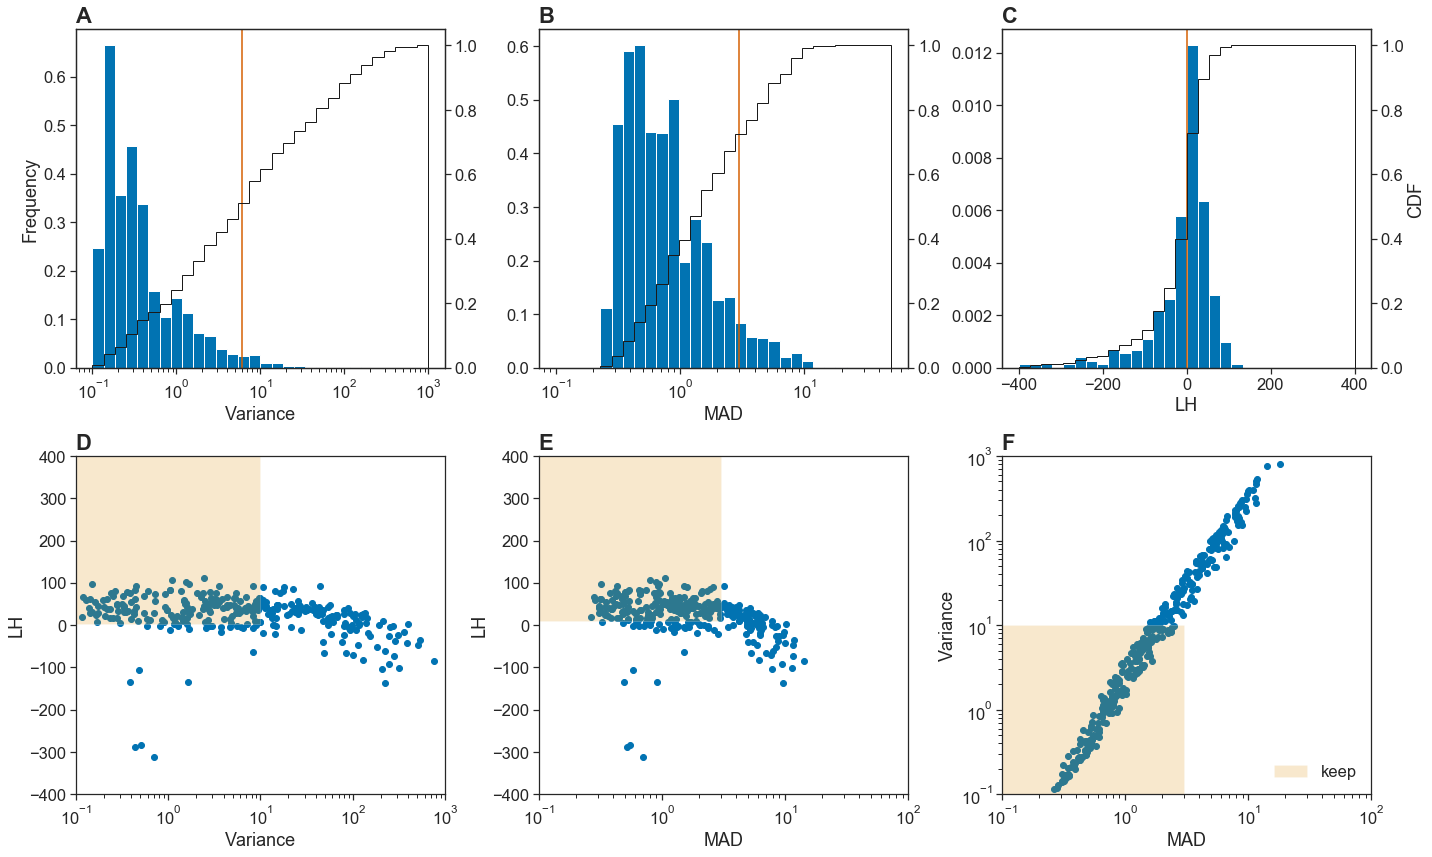

In [277]:
ruddick_fig6_kra(ds)